# Grading Analysis Visualizations

This notebook creates visualizations for inter-rater reliability analysis:
1. **Inter-Rater Reliability Plot** - Weighted Cohen's Kappa across rubric categories
2. **Violin Plot** - Score distributions across categories for humans vs LLMs
3. **Heatmap** - Inter-annotator agreement matrix

**Note**: Before running this notebook, ensure you have run `prepare_analysis.py` to generate the compiled CSV with all 5 human graders including shu.


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import seaborn as sns
from itertools import combinations
from sklearn.metrics import cohen_kappa_score
import warnings
import os
warnings.filterwarnings('ignore')

# Set style for publication-quality figures
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 150

# Create output directory
os.makedirs('results/analysis/batch1', exist_ok=True)


In [11]:
# Load the compiled grading data
# First run prepare_analysis.py to generate this file with shu included
df = pd.read_csv('results/analysis/batch1_compiled_grading_clean.csv')
print(f"Loaded {len(df)} submissions")
print(f"\nColumns: {list(df.columns)}")


Loaded 100 submissions

Columns: ['student_id', 'code', 'initial_input', 'initial_logic', 'initial_syntax', 'initial_print', 'final_input', 'final_logic', 'final_syntax', 'final_print', 'briana_input', 'briana_logic', 'briana_syntax', 'briana_print', 'chen_input', 'chen_logic', 'chen_syntax', 'chen_print', 'grace_input', 'grace_logic', 'grace_syntax', 'grace_print', 'sanya_input', 'sanya_logic', 'sanya_syntax', 'sanya_print', 'shu_input', 'shu_logic', 'shu_syntax', 'shu_print']


In [12]:
# Configuration
CATEGORIES = ['input', 'logic', 'syntax', 'print']
CATEGORY_LABELS = {
    'input': 'Input Handling',
    'logic': 'Conditional Logic',
    'syntax': 'Syntax Errors',
    'print': 'Print Statements'
}

# Check if shu columns exist
shu_cols_exist = any('shu_' in col for col in df.columns)

# Grader definitions
if shu_cols_exist:
    HUMAN_GRADERS = ['briana', 'chen', 'grace', 'sanya', 'shu']
    print("✅ All 5 human graders found in data (including shu)")
else:
    HUMAN_GRADERS = ['briana', 'chen', 'grace', 'sanya']
    print("⚠️  shu columns not found. Using 4 human graders.")
    print("   Run 'python prepare_analysis.py' to regenerate compiled CSV with shu")

AI_GRADERS = ['initial', 'final']
ALL_GRADERS = HUMAN_GRADERS + AI_GRADERS

GRADER_LABELS = {
    'briana': 'Human 1',
    'chen': 'Human 2',
    'grace': 'Human 3',
    'sanya': 'Human 4',
    'shu': 'Human 5',
    'initial': 'Single-LLM',
    'final': 'Multi-LLM'
}

print(f"\nHuman Graders: {HUMAN_GRADERS}")
print(f"AI Graders: {AI_GRADERS}")


✅ All 5 human graders found in data (including shu)

Human Graders: ['briana', 'chen', 'grace', 'sanya', 'shu']
AI Graders: ['initial', 'final']


## Helper Functions


In [13]:
def compute_weighted_kappa(grader1_col, grader2_col, df):
    """
    Compute weighted Cohen's kappa between two graders.
    Uses 'quadratic' weights for ordinal data (0, 1, 2 scale).
    """
    # Get valid pairs (both non-null)
    mask = df[grader1_col].notna() & df[grader2_col].notna()
    g1 = df.loc[mask, grader1_col].astype(int)
    g2 = df.loc[mask, grader2_col].astype(int)
    
    if len(g1) < 2:
        return np.nan
    
    try:
        # Use quadratic weights for ordinal data
        kappa = cohen_kappa_score(g1, g2, weights='quadratic', labels=[0, 1, 2])
        return kappa
    except:
        return np.nan


def compute_human_median_grades(df, category):
    """
    Compute the median grade across all human graders for each submission.
    """
    human_cols = [f'{grader}_{category}' for grader in HUMAN_GRADERS]
    # Only use columns that exist in the dataframe
    existing_cols = [c for c in human_cols if c in df.columns]
    return df[existing_cols].median(axis=1)


def get_pairwise_kappas_for_category(df, category, graders):
    """
    Compute all pairwise weighted kappas for a given category among specified graders.
    Returns list of kappa values.
    """
    kappas = []
    for g1, g2 in combinations(graders, 2):
        col1 = f'{g1}_{category}'
        col2 = f'{g2}_{category}'
        if col1 in df.columns and col2 in df.columns:
            kappa = compute_weighted_kappa(col1, col2, df)
            if not np.isnan(kappa):
                kappas.append(kappa)
    return kappas

print("Helper functions defined ✓")


Helper functions defined ✓


---
## 1. Inter-Rater Reliability Plot (Weighted Cohen's Kappa)

For each rubric category:
- **Purple**: Humans vs Humans (median + range from pairwise κ values)
- **Blue**: Humans (median) vs Single-LLM
- **Teal**: Humans (median) vs Multi-LLM
- **Dashed line**: Overall median human-human κ across all categories


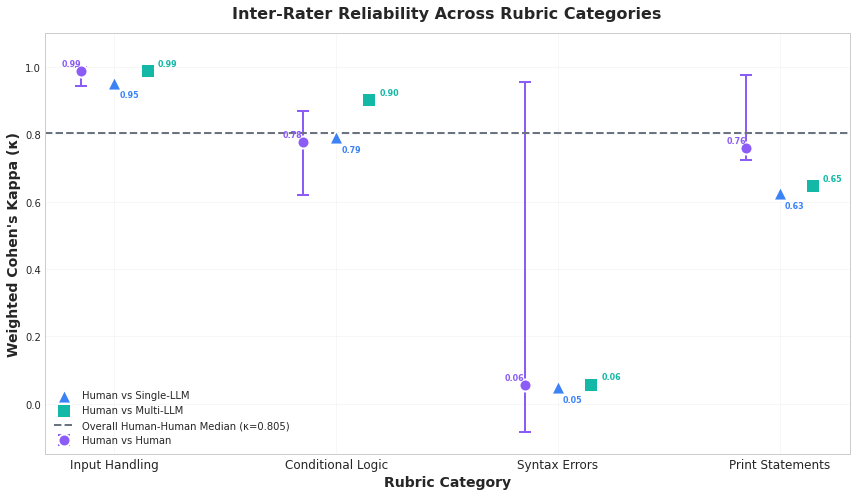


INTER-RATER RELIABILITY SUMMARY

Input Handling:
  Human-Human Median κ: 0.988 (range: 0.943 - 1.000)
  Human-Single-LLM κ: 0.954
  Human-Multi-LLM κ: 0.988

Conditional Logic:
  Human-Human Median κ: 0.776 (range: 0.620 - 0.869)
  Human-Single-LLM κ: 0.792
  Human-Multi-LLM κ: 0.901

Syntax Errors:
  Human-Human Median κ: 0.055 (range: -0.083 - 0.957)
  Human-Single-LLM κ: 0.049
  Human-Multi-LLM κ: 0.057

Print Statements:
  Human-Human Median κ: 0.759 (range: 0.723 - 0.977)
  Human-Single-LLM κ: 0.625
  Human-Multi-LLM κ: 0.647


In [12]:
def create_inter_rater_reliability_plot(df):
    """
    Create the inter-rater reliability DOT PLOT with weighted Cohen's kappa.
    - Circle (o) for Human vs Human
    - Triangle (^) for Human vs Single-LLM
    - Square (s) for Human vs Multi-LLM
    """
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Data storage
    x_positions = np.arange(len(CATEGORIES))
    
    human_medians = []
    human_ranges = []  # (min, max)
    single_llm_kappas = []
    multi_llm_kappas = []
    
    # For each category, compute kappas
    for category in CATEGORIES:
        # Human vs Human: pairwise kappas (C(n,2) pairs)
        human_kappas = get_pairwise_kappas_for_category(df, category, HUMAN_GRADERS)
        
        if human_kappas:
            human_medians.append(np.median(human_kappas))
            human_ranges.append((np.min(human_kappas), np.max(human_kappas)))
        else:
            human_medians.append(np.nan)
            human_ranges.append((np.nan, np.nan))
        
        # Compute human median grades for this category
        human_median_grades = compute_human_median_grades(df, category)
        
        # Create temporary df with human median
        temp_df = df.copy()
        temp_df['human_median'] = human_median_grades
        
        # Human median vs Single-LLM
        mask = temp_df['human_median'].notna() & temp_df[f'initial_{category}'].notna()
        if mask.sum() > 1:
            try:
                kappa_single = cohen_kappa_score(
                    temp_df.loc[mask, 'human_median'].round().astype(int),
                    temp_df.loc[mask, f'initial_{category}'].astype(int),
                    weights='quadratic',
                    labels=[0, 1, 2]
                )
            except:
                kappa_single = np.nan
        else:
            kappa_single = np.nan
        single_llm_kappas.append(kappa_single)
        
        # Human median vs Multi-LLM
        mask = temp_df['human_median'].notna() & temp_df[f'final_{category}'].notna()
        if mask.sum() > 1:
            try:
                kappa_multi = cohen_kappa_score(
                    temp_df.loc[mask, 'human_median'].round().astype(int),
                    temp_df.loc[mask, f'final_{category}'].astype(int),
                    weights='quadratic',
                    labels=[0, 1, 2]
                )
            except:
                kappa_multi = np.nan
        else:
            kappa_multi = np.nan
        multi_llm_kappas.append(kappa_multi)
    
    # Calculate error bars for human kappas
    human_yerr_low = [med - rng[0] if not np.isnan(med) else 0 for med, rng in zip(human_medians, human_ranges)]
    human_yerr_high = [rng[1] - med if not np.isnan(med) else 0 for med, rng in zip(human_medians, human_ranges)]
    
    # Colors
    purple = '#8B5CF6'  # Human vs Human
    blue = '#3B82F6'    # Single-LLM
    teal = '#14B8A6'    # Multi-LLM
    
    # Offset for dot positions
    offset = 0.15
    
    # Plot dots with error bars
    # Human vs Human - CIRCLE with error bars
    ax.errorbar(x_positions - offset, human_medians, 
                yerr=[human_yerr_low, human_yerr_high],
                fmt='o', markersize=12, color=purple, markeredgecolor='white',
                markeredgewidth=2, capsize=6, capthick=2, elinewidth=2,
                label='Human vs Human')
    
    # Human vs Single-LLM - TRIANGLE
    ax.scatter(x_positions, single_llm_kappas, 
               marker='^', s=200, color=blue, edgecolor='white', linewidth=2,
               label='Human vs Single-LLM', zorder=5)
    
    # Human vs Multi-LLM - SQUARE
    ax.scatter(x_positions + offset, multi_llm_kappas, 
               marker='s', s=180, color=teal, edgecolor='white', linewidth=2,
               label='Human vs Multi-LLM', zorder=5)
    
    # Overall median human-human kappa (dashed line)
    all_human_kappas = []
    for category in CATEGORIES:
        all_human_kappas.extend(get_pairwise_kappas_for_category(df, category, HUMAN_GRADERS))
    
    overall_median = np.median([k for k in all_human_kappas if not np.isnan(k)])
    ax.axhline(y=overall_median, color='#6B7280', linestyle='--', linewidth=2, 
               label=f'Overall Human-Human Median (κ={overall_median:.3f})')
    
    # Reference lines for interpretation
    # ax.axhline(y=0.8, color='#10B981', linestyle=':', alpha=0.5, linewidth=1)
    # ax.axhline(y=0.6, color='#F59E0B', linestyle=':', alpha=0.5, linewidth=1)
    # ax.text(3.55, 0.82, 'Substantial', fontsize=9, color='#10B981', alpha=0.7)
    # ax.text(3.55, 0.62, 'Moderate', fontsize=9, color='#F59E0B', alpha=0.7)
    
    # Labels and formatting
    ax.set_xlabel('Rubric Category', fontsize=14, fontweight='bold')
    ax.set_ylabel("Weighted Cohen's Kappa (κ)", fontsize=14, fontweight='bold')
    ax.set_title('Inter-Rater Reliability Across Rubric Categories', fontsize=16, fontweight='bold', pad=15)
    ax.set_xticks(x_positions)
    ax.set_xticklabels([CATEGORY_LABELS[c] for c in CATEGORIES], fontsize=12)
    ax.set_ylim(-0.15, 1.1)
    ax.legend(loc='lower left', framealpha=0.95, fontsize=10)
    
    # Add light grid
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)
    
    # Add value labels next to dots
    for i, (hm, sl, ml) in enumerate(zip(human_medians, single_llm_kappas, multi_llm_kappas)):
        if not np.isnan(hm):
            ax.annotate(f'{hm:.2f}', (i - offset, hm), textcoords='offset points',
                       xytext=(-20, 5), fontsize=8, color=purple, fontweight='bold')
        if not np.isnan(sl):
            ax.annotate(f'{sl:.2f}', (i, sl), textcoords='offset points',
                       xytext=(5, -15), fontsize=8, color=blue, fontweight='bold')
        if not np.isnan(ml):
            ax.annotate(f'{ml:.2f}', (i + offset, ml), textcoords='offset points',
                       xytext=(10, 5), fontsize=8, color=teal, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('results/analysis/batch1/inter_rater_reliability_kappa.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*60)
    print("INTER-RATER RELIABILITY SUMMARY")
    print("="*60)
    for i, category in enumerate(CATEGORIES):
        print(f"\n{CATEGORY_LABELS[category]}:")
        print(f"  Human-Human Median κ: {human_medians[i]:.3f} (range: {human_ranges[i][0]:.3f} - {human_ranges[i][1]:.3f})")
        print(f"  Human-Single-LLM κ: {single_llm_kappas[i]:.3f}")
        print(f"  Human-Multi-LLM κ: {multi_llm_kappas[i]:.3f}")
    
    return human_medians, single_llm_kappas, multi_llm_kappas

# Create the plot
kappa_results = create_inter_rater_reliability_plot(df)


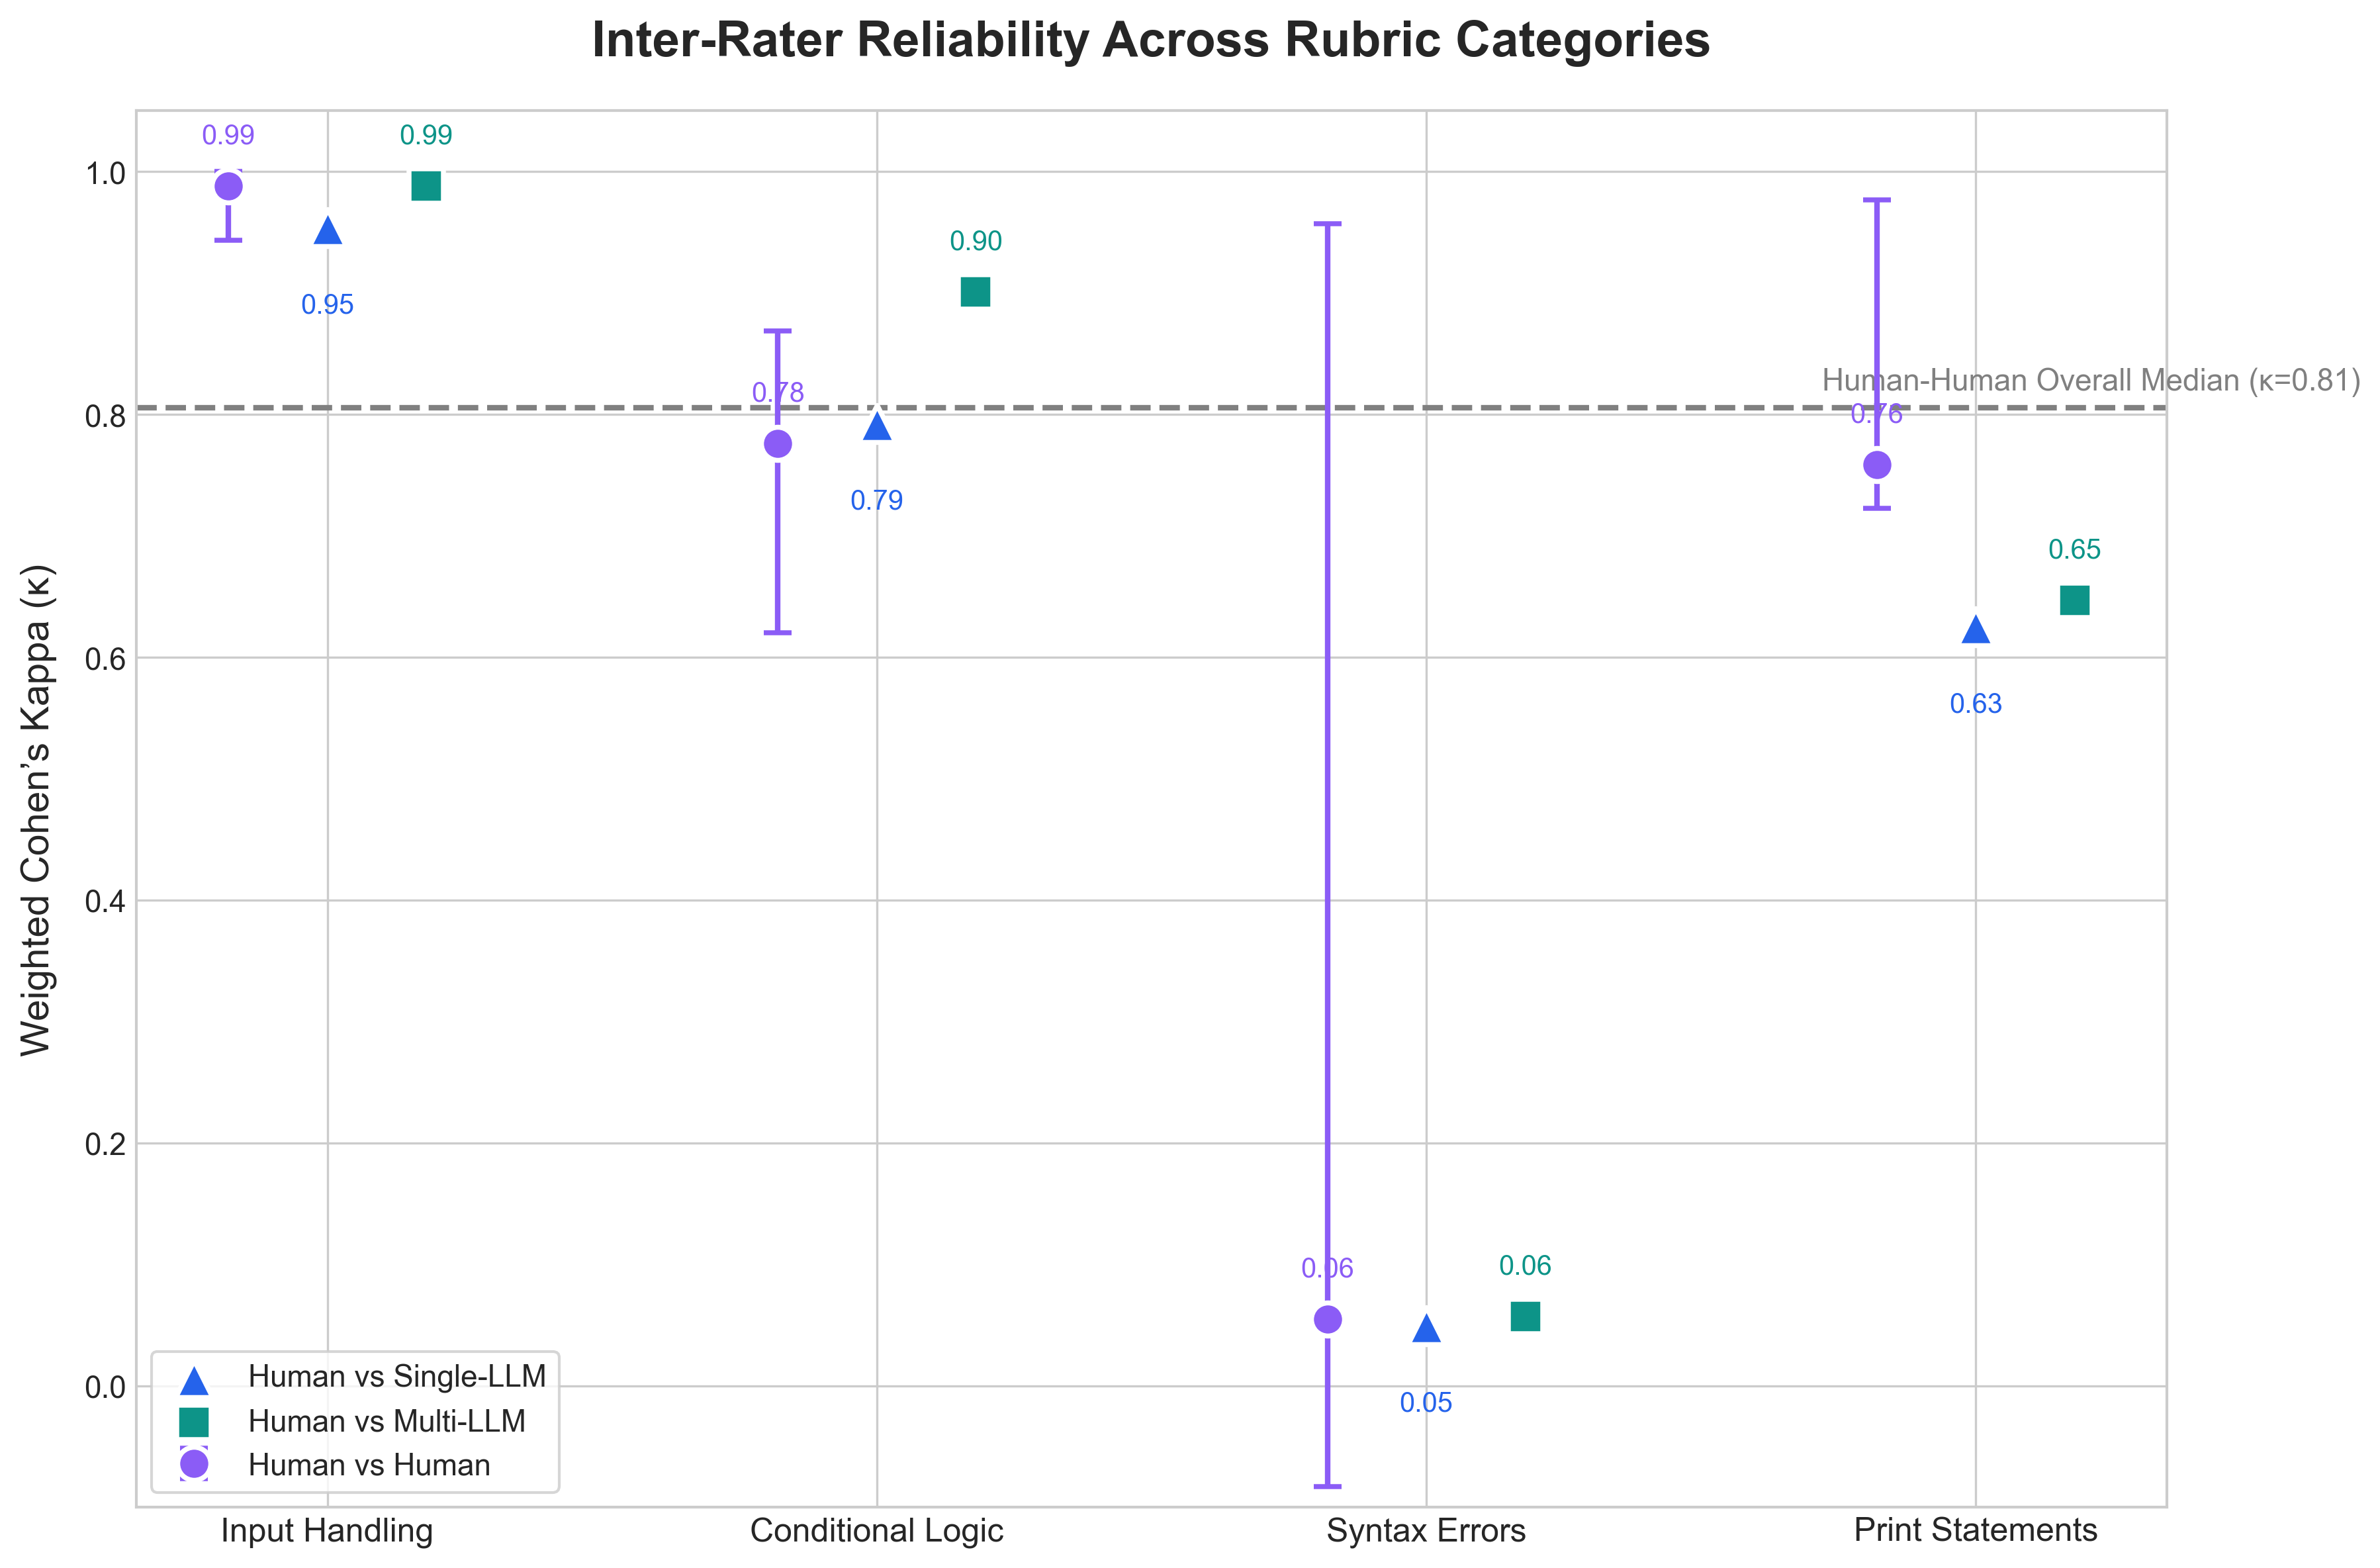

([0.9882352941176471,
  0.7761641801904022,
  0.05503235669546108,
  0.7588113618836014],
 [0.9537892791127541,
  0.7923438064283135,
  0.04936624416277524,
  0.6250914411119239],
 [0.9882352941176471,
  0.9007772449148338,
  0.05721716514954478,
  0.6468670771459616])

In [19]:
def create_inter_rater_reliability_plot_pretty(df):
    """
    Prettier version of inter-rater reliability DOT PLOT w/ weighted Cohen’s kappa.
    """

    plt.style.use("seaborn-v0_8-whitegrid")  # clean modern style

    fig, ax = plt.subplots(figsize=(12, 8), dpi=300)

    x_positions = np.arange(len(CATEGORIES))

    human_medians = []
    human_ranges = []
    single_llm_kappas = []
    multi_llm_kappas = []

    # Compute kappas
    for category in CATEGORIES:
        human_k = get_pairwise_kappas_for_category(df, category, HUMAN_GRADERS)
        med = np.nanmedian(human_k) if len(human_k) else np.nan
        human_medians.append(med)
        human_ranges.append((np.nanmin(human_k), np.nanmax(human_k)) if len(human_k) else (np.nan, np.nan))

        temp_df = df.copy()
        temp_df['human_median'] = compute_human_median_grades(df, category)

        # Single-LLM
        mask = temp_df['human_median'].notna() & temp_df[f'initial_{category}'].notna()
        try:
            single_llm_kappas.append(
                cohen_kappa_score(
                    temp_df.loc[mask, 'human_median'].round().astype(int),
                    temp_df.loc[mask, f'initial_{category}'].astype(int),
                    weights='quadratic',
                    labels=[0, 1, 2],
                )
            )
        except:
            single_llm_kappas.append(np.nan)

        # Multi-LLM
        mask = temp_df['human_median'].notna() & temp_df[f'final_{category}'].notna()
        try:
            multi_llm_kappas.append(
                cohen_kappa_score(
                    temp_df.loc[mask, 'human_median'].round().astype(int),
                    temp_df.loc[mask, f'final_{category}'].astype(int),
                    weights='quadratic',
                    labels=[0, 1, 2],
                )
            )
        except:
            multi_llm_kappas.append(np.nan)

    # Error bars for human vs human
    human_yerr_low = [m - lo if not np.isnan(m) else 0 for m, (lo, hi) in zip(human_medians, human_ranges)]
    human_yerr_high = [hi - m if not np.isnan(m) else 0 for m, (lo, hi) in zip(human_medians, human_ranges)]

    # Colors
    purple, blue, teal = "#8B5CF6", "#2563EB", "#0D9488"

    offset = 0.18

    # Plot
    ax.errorbar(
        x_positions - offset, human_medians,
        yerr=[human_yerr_low, human_yerr_high],
        fmt='o', markersize=12,
        color=purple, markeredgecolor="white", markeredgewidth=1.8,
        elinewidth=2, capsize=5, label="Human vs Human", zorder=4
    )

    ax.scatter(
        x_positions, single_llm_kappas,
        marker='^', s=180, color=blue, edgecolor="white", linewidth=1.8,
        label="Human vs Single-LLM", zorder=5
    )

    ax.scatter(
        x_positions + offset, multi_llm_kappas,
        marker='s', s=160, color=teal, edgecolor="white", linewidth=1.8,
        label="Human vs Multi-LLM", zorder=5
    )

    # Overall median dashed line
    combined = sum((get_pairwise_kappas_for_category(df, c, HUMAN_GRADERS) for c in CATEGORIES), [])
    overall_median = np.nanmedian(combined)
    ax.axhline(overall_median, linestyle="--", color="gray", linewidth=2)
    ax.text(
        len(CATEGORIES)-0.3, overall_median+0.015,
        f"Human-Human Overall Median (κ={overall_median:.2f})",
        fontsize=11, color="gray", ha="right"
    )

    # Annotations
    for i, (hm, sl, ml) in enumerate(zip(human_medians, single_llm_kappas, multi_llm_kappas)):
        if not np.isnan(hm):
            ax.text(i - offset, hm+0.035, f"{hm:.2f}", ha="center", fontsize=10, color=purple)

        if not np.isnan(sl):
            ax.text(i, sl-0.07, f"{sl:.2f}", ha="center", fontsize=10, color=blue)

        if not np.isnan(ml):
            ax.text(i + offset, ml+0.035, f"{ml:.2f}", ha="center", fontsize=10, color=teal)

    # Formatting & Style
    ax.set_xticks(x_positions)
    ax.set_xticklabels([CATEGORY_LABELS[c] for c in CATEGORIES], fontsize=12)
    ax.set_ylim(-0.1, 1.05)

    ax.set_title("Inter-Rater Reliability Across Rubric Categories",
                 fontsize=18, fontweight="bold", pad=20)

    ax.set_ylabel("Weighted Cohen’s Kappa (κ)", fontsize=14, labelpad=10)

    ax.tick_params(axis='y', labelsize=11)
    ax.legend(frameon=True, fontsize=11)

    plt.tight_layout()
    plt.savefig('results/analysis/batch1/inter_rater_reliability_pretty.png', dpi=400)
    plt.show()

    return human_medians, single_llm_kappas, multi_llm_kappas
create_inter_rater_reliability_plot_pretty(df)

## 2. Violin Plot - Score Distributions


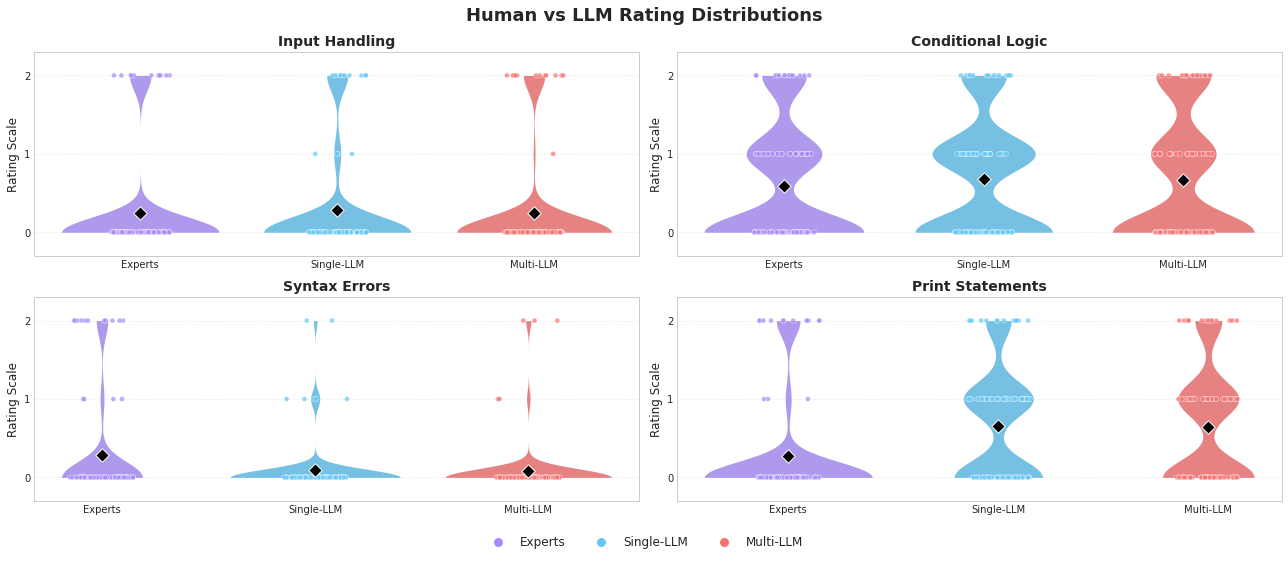

In [18]:
def create_violin_plot(df):
    """
    2x2 grid of violin+strip plots:
      - one panel per category
      - 3 violins per panel: Experts, Single-LLM, Multi-LLM
      - dots overlaid, black diamond means
      - shared bottom legend
    """
    fig, axes = plt.subplots(2, 2, figsize=(18, 8))
    axes = axes.flatten()

    colors = {
        'Experts':    '#A78BFA',  # purple
        'Single-LLM': '#63C7F5',  # light blue
        'Multi-LLM':  '#F87171',  # light red
    }
    grader_order = ['Experts', 'Single-LLM', 'Multi-LLM']

    for idx, category in enumerate(CATEGORIES):
        ax = axes[idx]

        # --- prepare data ---
        experts    = compute_human_median_grades(df, category).dropna()
        single_llm = df[f'initial_{category}'].dropna()
        multi_llm  = df[f'final_{category}'].dropna()

        groups = [experts, single_llm, multi_llm]

        plot_data = pd.DataFrame({
            "Score":  pd.concat(groups, ignore_index=True),
            "Grader": (["Experts"]    * len(experts) +
                       ["Single-LLM"] * len(single_llm) +
                       ["Multi-LLM"]  * len(multi_llm))
        })

        # --- VIOLIN SHAPE ---
        sns.violinplot(
            data=plot_data,
            x="Grader",
            y="Score",
            order=grader_order,
            palette=[colors[g] for g in grader_order],
            inner=None,        # no inner marks; we add our own
            cut=0,             # don’t extend beyond data range
            bw=0.3,
            linewidth=0,
            ax=ax
        )

        # --- DOTS ON TOP OF VIOLIN ---
        sns.stripplot(
            data=plot_data,
            x="Grader",
            y="Score",
            order=grader_order,
            hue="Grader",
            palette=colors,
            dodge=False,
            jitter=0.15,
            size=5,
            alpha=0.7,
            edgecolor="white",
            linewidth=0.5,
            ax=ax
        )

        # remove seaborn’s automatic legend for this axis
        leg = ax.get_legend()
        if leg is not None:
            leg.remove()

        # --- MEAN DIAMONDS ---
        for pos, data in enumerate(groups):
            ax.scatter(
                pos,
                data.mean(),
                marker='D',
                s=90,
                color='black',
                edgecolor='white',
                linewidth=1,
                zorder=10
            )

        # --- formatting ---
        ax.set_title(CATEGORY_LABELS[category], fontsize=14, fontweight='bold')
        ax.set_xlabel("")
        ax.set_ylabel("Rating Scale", fontsize=12)

        ax.set_ylim(-0.3, 2.3)
        ax.set_yticks([0, 1, 2])
        ax.grid(axis="y", linestyle="--", alpha=0.3)

    # --- shared legend at bottom center ---
    legend_elements = [
        plt.Line2D(
            [0], [0],
            marker='o',
            color='w',
            markerfacecolor=colors[label],
            markersize=10,
            label=label
        )
        for label in grader_order
    ]

    fig.legend(
        handles=legend_elements,
        loc='lower center',
        ncol=3,
        fontsize=12,
        framealpha=0.95,
        bbox_to_anchor=(0.5, 0.02)
    )

    plt.tight_layout(rect=[0, 0.08, 1, 0.95])
    fig.suptitle("Human vs LLM Rating Distributions",
                 fontsize=18, fontweight='bold')
    plt.savefig(
        "results/analysis/batch1/score_distribution_violin_style.png",
        dpi=300,
        bbox_inches="tight"
    )
    plt.show()

create_violin_plot(df)

## 3. Heatmap of Inter-Annotator Agreement

Shows pairwise agreement rates between all graders (5 humans + 2 LLMs) averaged across all categories.


In [17]:
    """
    Create a heatmap showing pairwise agreement rates between all graders.
    """
def create_agreement_heatmap(df):
    # Calculate pairwise agreement for all graders
    graders = HUMAN_GRADERS + AI_GRADERS
    n_graders = len(graders)
    
    # Matrix to store average agreement across categories
    agreement_matrix = np.zeros((n_graders, n_graders))
    
    for i, g1 in enumerate(graders):
        for j, g2 in enumerate(graders):
            if i == j:
                agreement_matrix[i, j] = 1.0  # Perfect agreement with self
            else:
                # Average weighted kappa across all categories
                kappas = []
                for category in CATEGORIES:
                    col1 = f'{g1}_{category}'
                    col2 = f'{g2}_{category}'
                    if col1 in df.columns and col2 in df.columns:
                        kappa = compute_weighted_kappa(col1, col2, df)
                        if not np.isnan(kappa):
                            kappas.append(kappa)
                
                agreement_matrix[i, j] = np.mean(kappas) if kappas else np.nan
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create heatmap
    labels = [GRADER_LABELS.get(g, g) for g in graders]
    
    heatmap = sns.heatmap(
        agreement_matrix,
        annot=True,
        fmt='.2f',
        cmap='RdYlGn',
        vmin=0,
        vmax=1,
        xticklabels=labels,
        yticklabels=labels,
        ax=ax,
        linewidths=0.5,
        annot_kws={'size': 10, 'weight': 'bold'},
        cbar_kws={'label': "Weighted Cohen's κ", 'shrink': 0.8}
    )
    
    ax.set_title("Inter-Annotator Agreement Heatmap\n(Weighted Cohen's κ, averaged across categories)", 
                fontsize=14, fontweight='bold', pad=15)
    
    # Rotate labels
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    # Add separating lines between humans and AI
    n_humans = len(HUMAN_GRADERS)
    ax.axhline(y=n_humans, color='#1F2937', linewidth=2)
    ax.axvline(x=n_humans, color='#1F2937', linewidth=2)
    
    plt.tight_layout()
    plt.savefig('results/analysis/batch1/agreement_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary
    print("\n" + "="*60)
    print("AGREEMENT MATRIX SUMMARY")
    print("="*60)
    
    # Human-Human average
    human_pairs = []
    for i in range(len(HUMAN_GRADERS)):
        for j in range(len(HUMAN_GRADERS)):
            if i < j:
                human_pairs.append(agreement_matrix[i, j])
    print(f"\nAverage Human-Human κ: {np.nanmean(human_pairs):.3f}")
    
    # Human-SingleLLM average
    single_llm_idx = graders.index('initial')
    human_single = [agreement_matrix[i, single_llm_idx] for i in range(len(HUMAN_GRADERS))]
    print(f"Average Human-Single-LLM κ: {np.nanmean(human_single):.3f}")
    
    # Human-MultiLLM average
    multi_llm_idx = graders.index('final')
    human_multi = [agreement_matrix[i, multi_llm_idx] for i in range(len(HUMAN_GRADERS))]
    print(f"Average Human-Multi-LLM κ: {np.nanmean(human_multi):.3f}")
    
    # LLM-LLM agreement
    print(f"Single-LLM vs Multi-LLM κ: {agreement_matrix[single_llm_idx, multi_llm_idx]:.3f}")
    
    return agreement_matrix


agreement_matrix = create_agreement_heatmap(df)


IndentationError: expected an indented block (117056135.py, line 6)

## 4. Category-wise Heatmaps (Bonus)


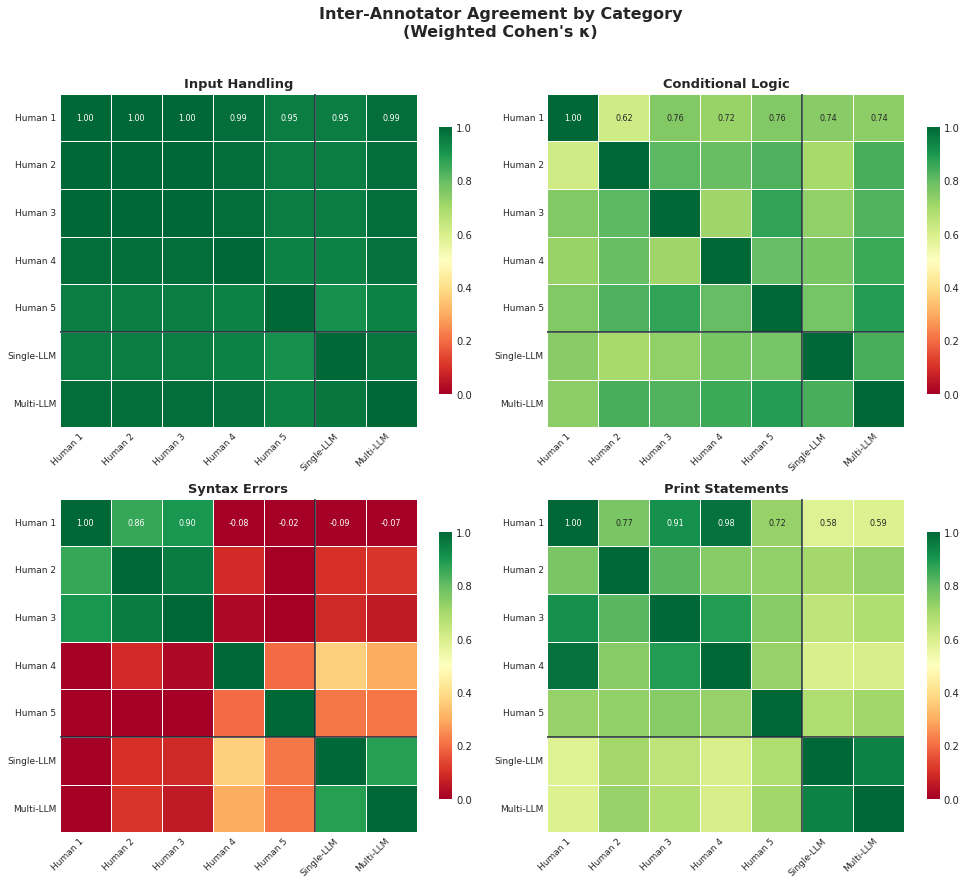

In [ ]:
def create_category_heatmaps(df):
    """
    Create separate heatmaps for each rubric category.
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    axes = axes.flatten()
    
    graders = HUMAN_GRADERS + AI_GRADERS
    labels = [GRADER_LABELS.get(g, g) for g in graders]
    n_graders = len(graders)
    
    for idx, category in enumerate(CATEGORIES):
        ax = axes[idx]
        
        # Calculate agreement matrix for this category
        matrix = np.zeros((n_graders, n_graders))
        for i, g1 in enumerate(graders):
            for j, g2 in enumerate(graders):
                if i == j:
                    matrix[i, j] = 1.0
                else:
                    col1 = f'{g1}_{category}'
                    col2 = f'{g2}_{category}'
                    if col1 in df.columns and col2 in df.columns:
                        matrix[i, j] = compute_weighted_kappa(col1, col2, df)
                    else:
                        matrix[i, j] = np.nan
        
        # Create heatmap
        sns.heatmap(
            matrix,
            annot=True,
            fmt='.2f',
            cmap='RdYlGn',
            vmin=0,
            vmax=1,
            xticklabels=labels,
            yticklabels=labels,
            ax=ax,
            linewidths=0.5,
            annot_kws={'size': 8},
            cbar_kws={'shrink': 0.8}
        )
        
        ax.set_title(f'{CATEGORY_LABELS[category]}', fontsize=13, fontweight='bold')
        ax.tick_params(axis='both', labelsize=9)
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
        
        # Add separating lines
        n_humans = len(HUMAN_GRADERS)
        ax.axhline(y=n_humans, color='#1F2937', linewidth=1.5)
        ax.axvline(x=n_humans, color='#1F2937', linewidth=1.5)
    
    fig.suptitle("Inter-Annotator Agreement by Category\n(Weighted Cohen's κ)", 
                fontsize=16, fontweight='bold', y=1.02)
    
    plt.tight_layout()
    plt.savefig('results/analysis/batch1/agreement_heatmaps_by_category.png', dpi=300, bbox_inches='tight')
    plt.show()

create_category_heatmaps(df)


## Summary


In [9]:
print("="*70)
print("COMPREHENSIVE GRADING ANALYSIS SUMMARY")
print("="*70)

print(f"\nTotal Submissions: {len(df)}")
print(f"Human Graders: {len(HUMAN_GRADERS)} ({', '.join(HUMAN_GRADERS)})")
print(f"AI Graders: {len(AI_GRADERS)} (Single-LLM, Multi-LLM)")
print(f"Rubric Categories: {len(CATEGORIES)} ({', '.join(CATEGORIES)})")

print("\n" + "-"*70)
print("SCORE DISTRIBUTIONS (Mean +/- Std)")
print("-"*70)

for category in CATEGORIES:
    print(f"\n{CATEGORY_LABELS[category]}:")
    
    # Human stats
    human_scores = []
    for grader in HUMAN_GRADERS:
        col = f'{grader}_{category}'
        if col in df.columns:
            human_scores.extend(df[col].dropna().tolist())
    if human_scores:
        print(f"  Humans (all): {np.mean(human_scores):.2f} +/- {np.std(human_scores):.2f}")
    
    # Human median
    median_scores = compute_human_median_grades(df, category).dropna()
    print(f"  Human Median: {median_scores.mean():.2f} +/- {median_scores.std():.2f}")
    
    # Single LLM
    single = df[f'initial_{category}'].dropna()
    print(f"  Single-LLM: {single.mean():.2f} +/- {single.std():.2f}")
    
    # Multi LLM
    multi = df[f'final_{category}'].dropna()
    print(f"  Multi-LLM: {multi.mean():.2f} +/- {multi.std():.2f}")

print("\n" + "="*70)
print("Files created in results/analysis/batch1/:")
print("="*70)
print("  - inter_rater_reliability_kappa.png")
print("  - score_distribution_violin.png")
print("  - agreement_heatmap.png")
print("  - agreement_heatmaps_by_category.png")


COMPREHENSIVE GRADING ANALYSIS SUMMARY

Total Submissions: 100
Human Graders: 5 (briana, chen, grace, sanya, shu)
AI Graders: 2 (Single-LLM, Multi-LLM)
Rubric Categories: 4 (input, logic, syntax, print)

----------------------------------------------------------------------
SCORE DISTRIBUTIONS (Mean +/- Std)
----------------------------------------------------------------------

Input Handling:
  Humans (all): 0.25 +/- 0.66
  Human Median: 0.24 +/- 0.65
  Single-LLM: 0.28 +/- 0.67
  Multi-LLM: 0.25 +/- 0.66

Conditional Logic:
  Humans (all): 0.61 +/- 0.81
  Human Median: 0.59 +/- 0.75
  Single-LLM: 0.68 +/- 0.74
  Multi-LLM: 0.67 +/- 0.80

Syntax Errors:
  Humans (all): 0.22 +/- 0.58
  Human Median: 0.28 +/- 0.67
  Single-LLM: 0.09 +/- 0.35
  Multi-LLM: 0.08 +/- 0.37

Print Statements:
  Humans (all): 0.34 +/- 0.70
  Human Median: 0.27 +/- 0.66
  Single-LLM: 0.66 +/- 0.71
  Multi-LLM: 0.64 +/- 0.73

Files created in results/analysis/batch1/:
  - inter_rater_reliability_kappa.png
  - s